<a href="https://colab.research.google.com/github/carlotamartin/Cats-and-dogs/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/train.zip

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import copy
from sklearn.metrics import classification_report
import random
import numpy as np
from numpy import vstack
from numpy import argmax
import matplotlib.pyplot as plt

In [ ]:
## Step 1: Create a dataloader for Pytorch
class CatDogDataset(Dataset):
    def __init__(self, train_dir, img_list, transform = None):
        self.train_dir = train_dir
        self.transform = transform
        self.images = img_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.train_dir, self.images[index])
        label = self.images[index].split(".")[0]
        label = 0 if label == 'cat' else 1
        img = cv2.imread(image_path)
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label)


In [ ]:
## Step 2: Create training dataset
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip()
])

In [ ]:
# Create dataloaders
train_dir = 'predict_cat_dog'
images_paths = os.listdir(train_dir)
random.shuffle(images_paths)
train_img_list = images_paths[0:20000]
val_img_list = images_paths[20000:25000]
train_img_list = images_paths[0:2000]
val_img_list = images_paths[2000:2500]
train_dataset = CatDogDataset(train_dir, train_img_list, transform = data_transform)
val_dataset = CatDogDataset(train_dir, val_img_list, transform = data_transform)
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle=False)

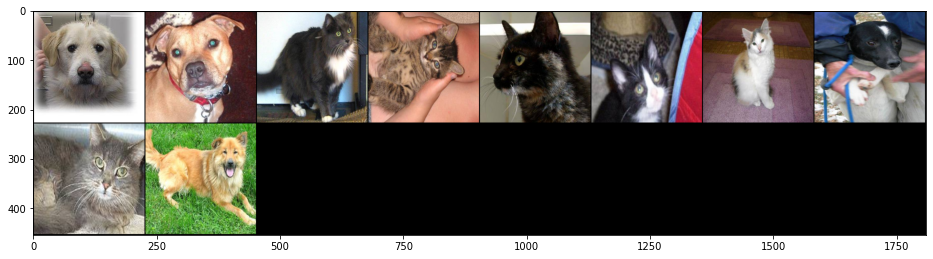

In [ ]:
# Visualize images in the dataset
samples, labels = next(iter(train_dataloader))
plt.figure(figsize=(16,32))
grid_imgs = torchvision.utils.make_grid(samples[:32])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(cv2.cvtColor(np.transpose(np_grid_imgs, (1,2,0)), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
## Step 3: Define Deep Learning model
class scratch_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=100, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(100, 200, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(200, 400, 3, stride=1, padding=0)
        self.mpool = nn.MaxPool2d(kernel_size=3)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(19600,1024)
        self.linear2 = nn.Linear(1024,512)
        self.linear3 = nn.Linear(512,2)
        self.classifier = nn.Softmax(dim=1)

    def forward(self,x):
        x = self.mpool( self.relu(self.conv1(x)) )
        x = self.mpool( self.relu(self.conv2(x)) )
        x = self.mpool( self.relu(self.conv3(x)) )
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.classifier(x)
        return x

In [ ]:
## Step 4: Define train_step and predict functions
def train_step(train_loader, model, optimizer, criterion, device):
    # define the optimization
    avg_loss = []
    predictions, actuals = list(), list()
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(inputs)
        # calculate loss
        loss = criterion(yhat, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
        avg_loss.append(loss.item())
        # Get accruacy
        actual = targets.cpu().numpy()
        yhat = argmax(yhat.detach().cpu().numpy(), axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)

    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return sum(avg_loss)/len(avg_loss), acc


In [ ]:
# evaluate the model
def evaluation_step(val_loader, model, criterion, device):
    avg_loss = []
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # evaluate the model on the test set
        yhat = model(inputs)
        loss = criterion(yhat, targets)
        avg_loss.append(loss.item())
        # retrieve numpy array
        yhat = yhat.detach().cpu().numpy()
        actual = targets.cpu().numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)

    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return sum(avg_loss)/len(avg_loss), acc

In [ ]:
## Step 5: Define main train function
def train(model, train_dataloader, val_dataloader, optimizer, criterion, device):
    num_epoch = 30
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
    for epoch in range(1, num_epoch + 1):
        train_loss, train_acc = train_step(train_dataloader, model, optimizer, criterion, device)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc*100)
        print(f"Train: Loss at epoch {epoch} is {train_loss} and accuracy is {train_acc}%")
        val_loss, val_acc = evaluation_step(val_dataloader, model, criterion, device)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc*100)
        print(f"Validation: Loss at epoch {epoch} is {val_loss} and accuracy is {val_acc}%")
        torch.save(model.state_dict(), model_file_name)
    return model, train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [ ]:
# Step 6: Training parameters, model declaration and training/validation process
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = scratch_nn()
model = model.to(device)

In [ ]:
lr = 0.001
weight_dec = 0.001
model_file_name = "dogs_cats_model.pth"
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_dec)
criterion = nn.CrossEntropyLoss()


In [ ]:
model, train_loss, train_acc, val_loss, val_acc = train(model, train_dataloader, val_dataloader, optimizer, criterion, device)

Train: Loss at epoch 1 is 0.6807506084442139 and accuracy is 1.0%


ValueError: ignored

In [ ]:
+# Step 7: Show results
plt.figure(1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Loss in training and validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.figure(2)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title("Accuracy in training and validation")
plt.xlabel("Epochs")
plt.ylabel("Acuracy (%)")
plt.legend(["Train", "Validation"])

plt.show()